In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import time
from torchvision import models
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import torchvision.transforms as T
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

In [2]:
code = {'AD':1, 'CN':0}
class ADNIAxialDataset(Dataset):
    def __init__(self, csv_path, transform=None, n_slices=80):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df.Group != "MCI"]
        self.transform = transform
        self.n_slices = n_slices

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        label = code[self.df.iloc[idx]['Group']]

        img = nib.load(path).get_fdata()  # shape: (H, W, D)
        img = np.transpose(img, (2, 0, 1))  # axial: (D, H, W)

        center = img.shape[0] // 2
        start = center - self.n_slices // 2
        end = center + self.n_slices // 2
        slices = img[start:end]  # shape: (n_slices, H, W)

        if self.transform:
            slices = torch.stack([self.transform(slice_) for slice_ in slices])
        else:
            slices = torch.tensor(slices).unsqueeze(1).float()  # (N, 1, H, W)

        return slices, label

In [3]:
class AttentionFusion(nn.Module):
    def __init__(self, fdim):
        super().__init__()
        self.attn = nn.Linear(fdim, 1)

    def forward(self, features):  # (B, N, fdim)
        weights = self.attn(features).squeeze(-1)  # (B, N)
        alpha = torch.softmax(weights, dim=1).unsqueeze(-1)  # (B, N, 1)
        fused = (alpha * features).sum(dim=1)  # (B, fdim)
        return fused

class AXIALModel(nn.Module):
    def __init__(self, base='vgg16'):
        super().__init__()
        base_model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        self.features = base_model.features
        self.features[:20].requires_grad_(False)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fdim = 512
        self.dropout = nn.Dropout(0.3)

        self.attn_fusion = AttentionFusion(self.fdim)
        self.classifier = nn.Linear(self.fdim, 2)

    def forward(self, x):  # x: (B, N, 1, 224, 224)
        B, N, _, H, W = x.shape
        x = x.view(B * N, 1, H, W)
        x = x.repeat(1, 3, 1, 1)  # convert to 3 channels
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)  # (B*N, fdim)
        x = x.view(B, N, -1)
        fused = self.attn_fusion(x)
        fused = self.dropout(fused)
        out = self.classifier(fused)
        return out


In [4]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, epochs, device):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=(df["Group"]=="AD").values)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    best_acc = 0
    train_loss, train_acc = [], []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        losses, preds, labels = [], [], []
        scaler = torch.amp.GradScaler('cuda')
        
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            
            with torch.amp.autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            losses.append(loss.item())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
        acc = accuracy_score(labels, preds)
        print(f"[Epoch {epoch+1}] Train Loss: {sum(losses)/len(losses):.4f}, Acc: {acc:.4f}")
        train_loss.append(sum(losses)/len(losses))
        train_acc.append(acc)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_preds.extend(out.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"          Val Acc: {val_acc:.4f}")
        val_accs.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
        torch.cuda.empty_cache()
    return train_loss, train_acc, val_accs

In [5]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
])

df = pd.read_csv("/kaggle/input/adni-csv-with-path/adni_with_path.csv")
df = df[df.Group != 'MCI']
train_idx, val_idx = train_test_split(range(len(df)), test_size=0.2, stratify=df["Group"])

train_ds = ADNIAxialDataset("/kaggle/input/adni-csv-with-path/adni_with_path.csv", transform=transform)
val_ds = ADNIAxialDataset("/kaggle/input/adni-csv-with-path/adni_with_path.csv", transform=transform)

train_loader = DataLoader(Subset(train_ds, train_idx), batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(Subset(val_ds, val_idx), batch_size=4, shuffle=False, num_workers=2)

model = AXIALModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=20, device=device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 240MB/s] 
100%|██████████| 24/24 [01:04<00:00,  2.70s/it]

[Epoch 1] Train Loss: 0.6940, Acc: 0.4866


          Val Acc: 0.4468


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 2] Train Loss: 0.6638, Acc: 0.6257


          Val Acc: 0.4468


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 3] Train Loss: 0.6252, Acc: 0.6310


          Val Acc: 0.5745


100%|██████████| 24/24 [01:00<00:00,  2.54s/it]

[Epoch 4] Train Loss: 0.5597, Acc: 0.7273


          Val Acc: 0.5532


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 5] Train Loss: 0.5407, Acc: 0.7273


          Val Acc: 0.5957


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 6] Train Loss: 0.4688, Acc: 0.7968


          Val Acc: 0.5319


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 7] Train Loss: 0.4766, Acc: 0.7540


          Val Acc: 0.5745


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 8] Train Loss: 0.4269, Acc: 0.8449


          Val Acc: 0.5106


100%|██████████| 24/24 [01:00<00:00,  2.54s/it]

[Epoch 9] Train Loss: 0.4045, Acc: 0.8235


          Val Acc: 0.4681


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 10] Train Loss: 0.3732, Acc: 0.8503


          Val Acc: 0.6170


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 11] Train Loss: 0.3164, Acc: 0.8770


          Val Acc: 0.4894


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 12] Train Loss: 0.2517, Acc: 0.9305


          Val Acc: 0.5319


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 13] Train Loss: 0.2410, Acc: 0.9091


          Val Acc: 0.5745


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 14] Train Loss: 0.1745, Acc: 0.9412


          Val Acc: 0.5319


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 15] Train Loss: 0.1708, Acc: 0.9519


          Val Acc: 0.6170


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 16] Train Loss: 0.1529, Acc: 0.9519


          Val Acc: 0.5106


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 17] Train Loss: 0.1192, Acc: 0.9786


          Val Acc: 0.5532


100%|██████████| 24/24 [01:00<00:00,  2.52s/it]

[Epoch 18] Train Loss: 0.1561, Acc: 0.9305


          Val Acc: 0.4681


100%|██████████| 24/24 [01:00<00:00,  2.51s/it]

[Epoch 19] Train Loss: 0.1020, Acc: 0.9679


          Val Acc: 0.6596


100%|██████████| 24/24 [01:00<00:00,  2.53s/it]

[Epoch 20] Train Loss: 0.0992, Acc: 0.9840


          Val Acc: 0.5532


Accuracy:  0.5532
Precision: 0.4545
Recall:    0.5263
F1-score:  0.4878
Confusion Matrix:
[[16 12]
 [ 9 10]]


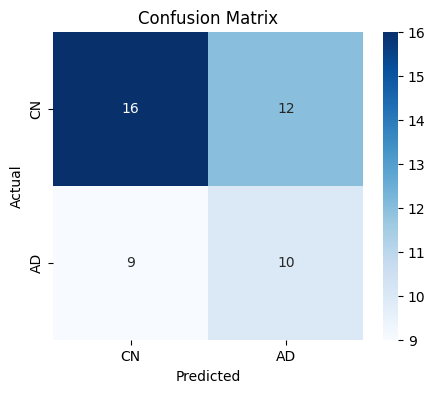

20


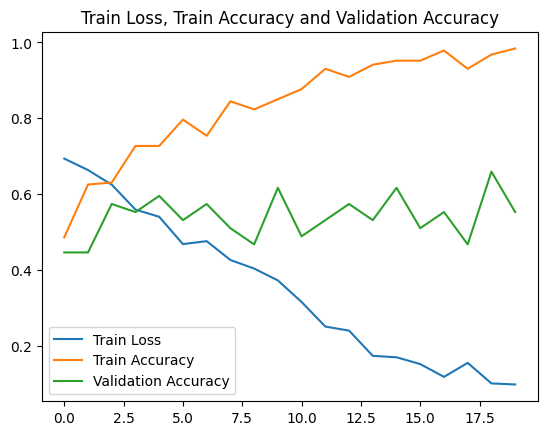

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(m_name, model, test_loader, device, train_loss, train_acc, val_acc):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            if isinstance(outputs, tuple):  # If model returns (logits, attention)
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(f"{m_name}_confusion_matrix.png")
    plt.show()

    plt.plot(train_loss, label='Train Loss')
    print(len(train_loss),end='\n')
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label= 'Validation Accuracy')
    plt.legend()
    plt.title("Train Loss, Train Accuracy and Validation Accuracy")
    plt.savefig(f"{m_name}_loss_and_acc_graph.png")
    plt.show()

evaluate_model("mobile_net",model, val_loader, device, train_loss, train_acc, val_acc)